<a href="https://colab.research.google.com/github/sudarshanmungi39/CrimePrediction/blob/main/Hackathon_group06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from logging import warning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, log_loss, f1_score, RocCurveDisplay
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# --- MICE / IterativeImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

# Repro / performance
RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1

In [42]:
# STEP 1: Load data

train_path = "dataset_B_training.csv"
test_path  = "dataset_B_testing.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print(f"Train shape: {train.shape} | Test shape: {test.shape}")
assert "h1n1_vaccine" in train.columns, "Target 'h1n1_vaccine' missing from training data."

X = train.drop(columns=["h1n1_vaccine", "respondent_id"])
y = train["h1n1_vaccine"].astype(int)
X_test_final = test.drop(columns=["respondent_id"])

num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64","float64"]).columns.tolist()
print(f"Numeric: {len(num_cols)}, Categorical: {len(cat_cols)}")

Train shape: (4756, 31) | Test shape: (4749, 30)
Numeric: 19, Categorical: 10



=== Missing values (top 15) ===
employment_sector              2364
health_insurance               1925
income_poverty                  712
doctor_recc_h1n1                319
rent_or_own                     315
employment_status               235
marital_status                  226
education                       224
chronic_med_condition           161
child_under_6_months            134
health_worker                   131
opinion_h1n1_vacc_effective      69
opinion_h1n1_risk                64
opinion_h1n1_sick_from_vacc      64
household_children               34
dtype: int64

=== Target balance ===
h1n1_vaccine
class_0    0.606
class_1    0.394
Name: proportion, dtype: float64


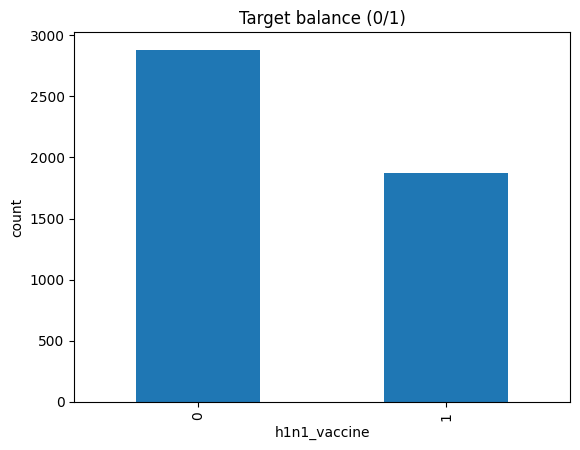

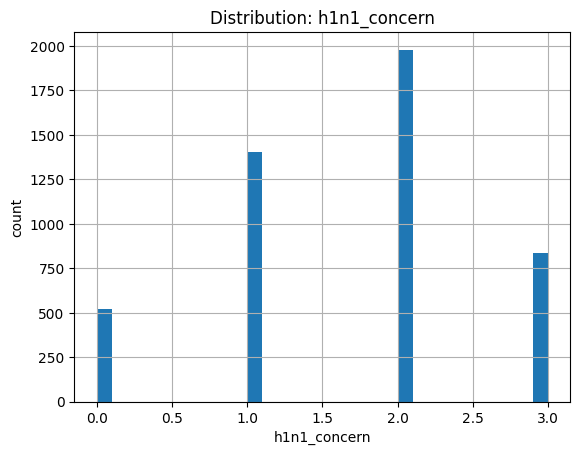

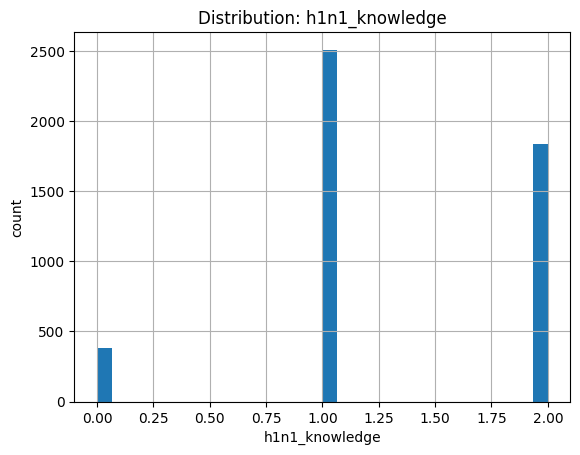

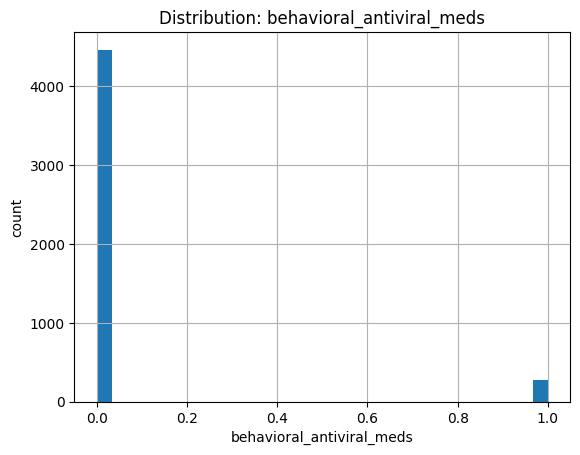

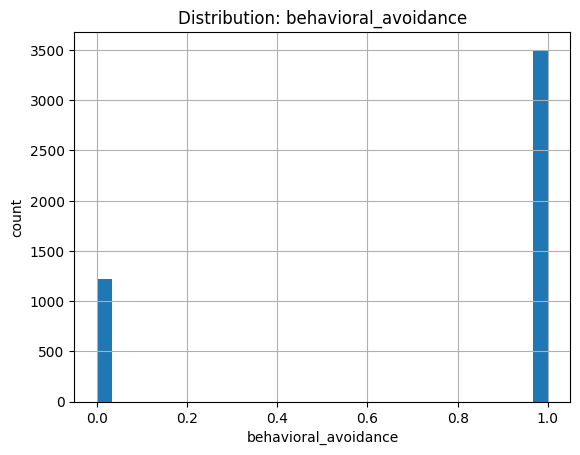

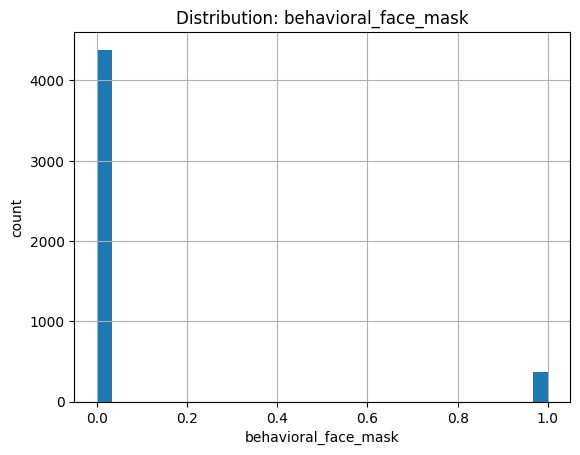

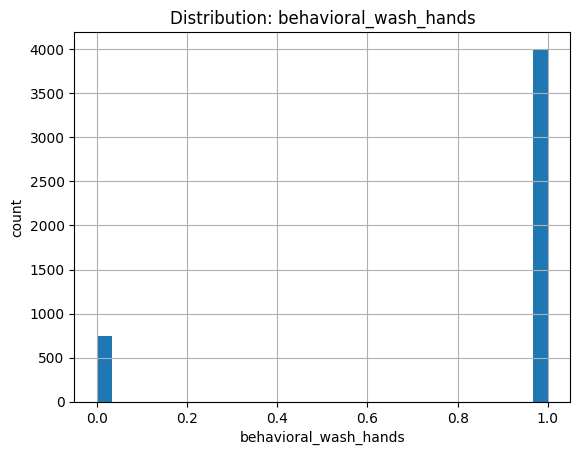

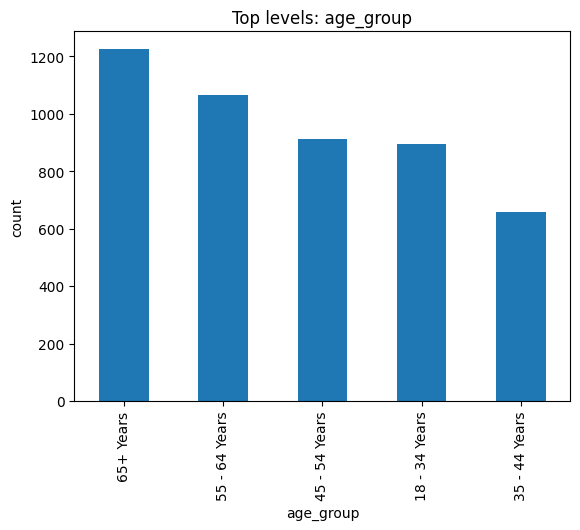

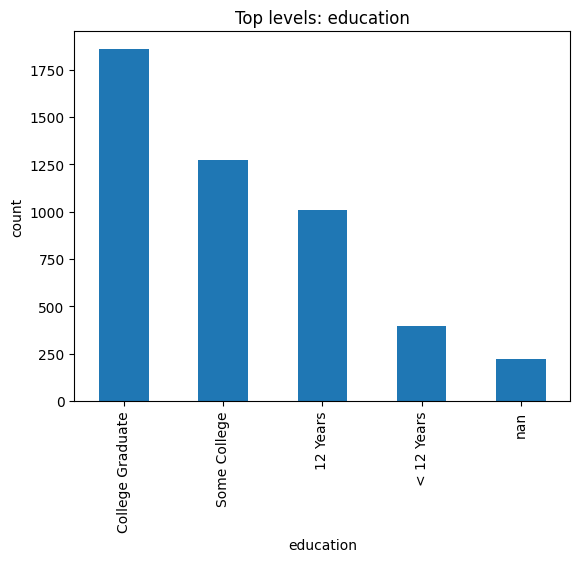

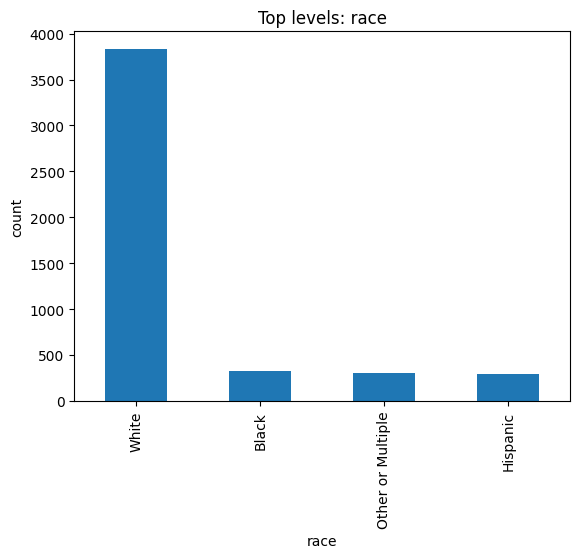

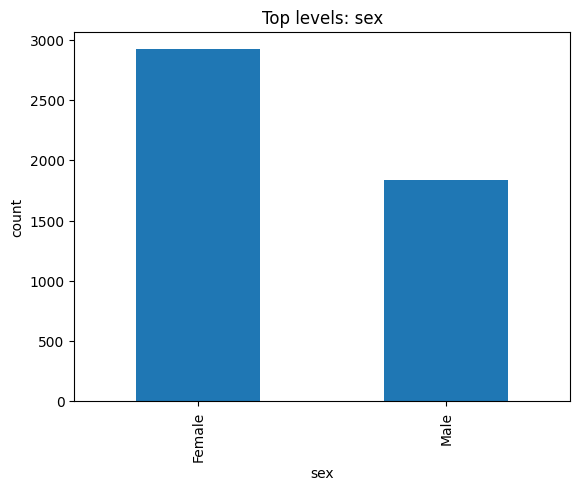

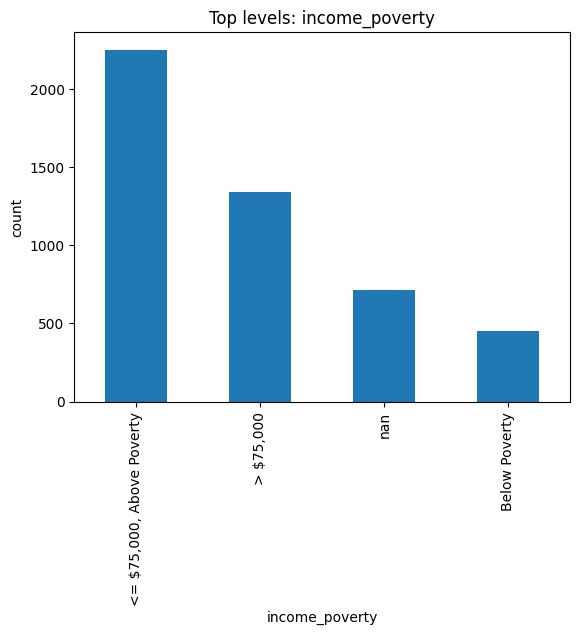

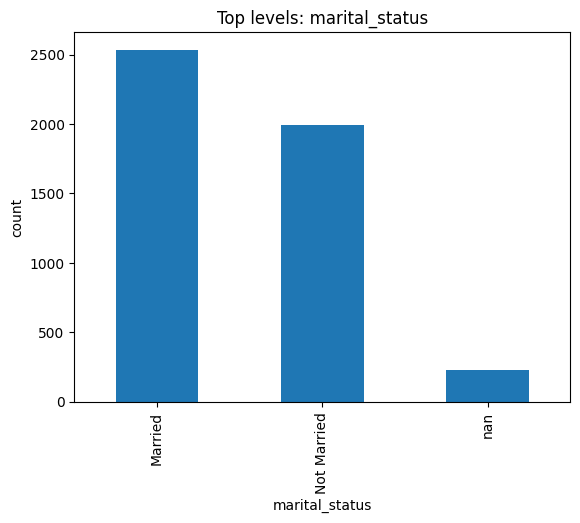

In [43]:
# STEP 2: Quick EDA

print("\n=== Missing values (top 15) ===")
print(X.isna().sum().sort_values(ascending=False).head(15))

print("\n=== Target balance ===")
print(y.value_counts(normalize=True).rename({0:"class_0",1:"class_1"}).round(3))

# Target balance plot
y.value_counts().plot(kind="bar", title="Target balance (0/1)")
plt.xlabel("h1n1_vaccine"); plt.ylabel("count"); plt.show()

# Numeric distributions (first 6 to keep runtime light)
for col in num_cols[:6]:
    X[col].hist(bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col); plt.ylabel("count")
    plt.show()

# Categorical top levels (first 6)
for col in cat_cols[:6]:
    X[col].value_counts(dropna=False).head(12).plot(kind="bar")
    plt.title(f"Top levels: {col}")
    plt.xlabel(col); plt.ylabel("count")
    plt.show()

In [44]:
# STEP 3: Preprocessing variants
# =====================================================
cat_base = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# A) Baseline
num_base = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
pp_baseline = ColumnTransformer([
    ("num", num_base, num_cols),
    ("cat", cat_base, cat_cols)
])

# B) Yeo–Johnson
num_yj = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("yj", PowerTransformer(method="yeo-johnson")),
    ("scaler", StandardScaler())
])
pp_yj = ColumnTransformer([
    ("num", num_yj, num_cols),
    ("cat", cat_base, cat_cols)
])

# C) Quantile binning
bin_targets = [c for c in ["household_children", "household_adults"] if c in num_cols]
num_rest = [c for c in num_cols if c not in bin_targets]
num_rest_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
bin_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("kbins", KBinsDiscretizer(n_bins=3, encode="onehot-dense", strategy="quantile"))
])
transformers = []
if num_rest: transformers.append(("num_cont", num_rest_pipe, num_rest))
if bin_targets: transformers.append(("num_binned", bin_pipe, bin_targets))
transformers.append(("cat", cat_base, cat_cols))
pp_binning = ColumnTransformer(transformers)

# D) MICE-style Iterative Imputation
num_iter = Pipeline([
    ("imp", IterativeImputer(
        estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
        max_iter=10, random_state=RANDOM_STATE
    )),
    ("scaler", StandardScaler())
])
pp_iterative = ColumnTransformer([
    ("num", num_iter, num_cols),
    ("cat", cat_base, cat_cols)
])

prepro_options = {
    "A_baseline": pp_baseline,
    "B_yeojohnson": pp_yj,
    "C_binning": pp_binning,
    "D_iterative": pp_iterative
}

In [45]:
# STEP 4: Models
# =====================================================
models = {
    "logreg": LogisticRegression(max_iter=4000, C=1.0, solver="lbfgs", random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=400, max_depth=12, random_state=RANDOM_STATE, n_jobs=N_JOBS),
    "xgb": XGBClassifier(
        n_estimators=600, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=N_JOBS
    ),
    "dt": DecisionTreeClassifier(max_depth=8, random_state=RANDOM_STATE),
    "nb": GaussianNB()
}

In [60]:
# STEP 5: Cross-validation metrics helper (AUC, LogLoss, F1)
# =====================================================
from sklearn.metrics import roc_auc_score, log_loss, f1_score

def cv_metrics(pipe, X, y, folds=5):
    """Compute mean AUC, LogLoss, and F1 across CV folds."""
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    aucs, logs, f1s = [], [], []
    for tr_idx, va_idx in skf.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        pipe.fit(Xtr, ytr)
        p = pipe.predict_proba(Xva)[:, 1]
        preds = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(yva, p))
        logs.append(log_loss(yva, p))
        f1s.append(f1_score(yva, preds))
    return (
        np.mean(aucs), np.std(aucs),
        np.mean(logs), np.std(logs),
        np.mean(f1s), np.std(f1s)
    )


In [66]:
# STEP 6: Model + Preprocessing CV Sweep

results = []
print("\n=== CV sweep (this will take a bit) ===")
for pp_name, prepro in prepro_options.items():
    for m_name, model in models.items():
        label = f"{pp_name}__{m_name}"
        pipe = Pipeline([("pp", prepro), ("clf", model)])
        auc_m, auc_s, log_m, log_s, f1_m, f1_s = cv_metrics(pipe, X, y, folds=N_FOLDS)
        results.append({
            "setup": label, "prepro": pp_name, "model": m_name,
            "cv_auc_mean": auc_m, "cv_auc_std": auc_s,
            "cv_logloss_mean": log_m, "cv_logloss_std": log_s
        })
        print(f"{label:28s}  AUC {auc_m:.4f}±{auc_s:.3f}  LogLoss {log_m:.4f}±{log_s:.3f}  F1 {f1_m:.4f}")

res_df = pd.DataFrame(results).sort_values(
    ["cv_auc_mean", "cv_logloss_mean"], ascending=[False, True]
)
print("\n=== CV summary (top 10) ===")
print(res_df.head(10).to_string(index=False))


=== CV sweep (this will take a bit) ===
A_baseline__logreg            AUC 0.8224±0.013  LogLoss 0.4998±0.015  F1 0.6847
A_baseline__rf                AUC 0.8235±0.012  LogLoss 0.5097±0.011  F1 0.6743
A_baseline__xgb               AUC 0.8163±0.017  LogLoss 0.5251±0.030  F1 0.6810
A_baseline__dt                AUC 0.7630±0.024  LogLoss 1.7726±0.303  F1 0.6379
A_baseline__nb                AUC 0.7360±0.011  LogLoss 3.6341±0.732  F1 0.5984
B_yeojohnson__logreg          AUC 0.8240±0.012  LogLoss 0.4981±0.015  F1 0.6857
B_yeojohnson__rf              AUC 0.8236±0.012  LogLoss 0.5097±0.011  F1 0.6739
B_yeojohnson__xgb             AUC 0.8163±0.017  LogLoss 0.5251±0.030  F1 0.6810
B_yeojohnson__dt              AUC 0.7630±0.024  LogLoss 1.7726±0.303  F1 0.6379
B_yeojohnson__nb              AUC 0.7343±0.012  LogLoss 3.6491±0.742  F1 0.5984
C_binning__logreg             AUC 0.8227±0.013  LogLoss 0.4996±0.015  F1 0.6838
C_binning__rf                 AUC 0.8241±0.013  LogLoss 0.5086±0.012  F1 0.6747

In [52]:
top3 = res_df.head(3)
tuned_models = []
for _, row in top3.iterrows():
    pp = prepro_options[row["prepro"]]
    base = row["model"]
    if base == "rf":
        est = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)
        grid = {
            "clf__n_estimators": [300, 500, 800],
            "clf__max_depth": [8, 12, 16, None],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    elif base == "xgb":
        est = XGBClassifier(eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=N_JOBS)
        grid = {
            "clf__n_estimators": [400, 600, 800],
            "clf__max_depth": [4, 5, 6],
            "clf__learning_rate": [0.03, 0.05, 0.08],
            "clf__subsample": [0.7, 0.8, 1.0],
            "clf__colsample_bytree": [0.7, 0.8, 1.0]
        }
    elif base == "logreg":
        est = LogisticRegression(max_iter=6000, solver="lbfgs", random_state=RANDOM_STATE)
        grid = {"clf__C": np.logspace(-2, 2, 9)}
    elif base == "dt":
        est = DecisionTreeClassifier(random_state=RANDOM_STATE)
        grid = {
            "clf__max_depth": [4, 6, 8, 12, None],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    else:
        tuned_models.append((f'{row["prepro"]}__{row["model"]}__TUNED',
                             Pipeline([("pp", pp), ("clf", GaussianNB())])))
        continue

    pipe = Pipeline([("pp", pp), ("clf", est)])
    rs = RandomizedSearchCV(pipe, grid, n_iter=12, scoring="roc_auc",
                            cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE),
                            random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=0)
    rs.fit(X, y)
    tuned_models.append((f'{row["prepro"]}__{row["model"]}__TUNED', rs.best_estimator_))

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=12. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [63]:
# STEP 8: Final Top-5 ranking + Predictions (fixed)
# =====================================================

final_candidates = tuned_models.copy()
for _, row in res_df.iterrows():
    if len(final_candidates) >= 5:
        break
    label = f'{row["prepro"]}__{row["model"]}'
    if any(label in name for name, _ in final_candidates):
        continue
    est = Pipeline([("pp", prepro_options[row["prepro"]]), ("clf", models[row["model"]])])
    final_candidates.append((label, est))

ranked = []
for name, est in final_candidates:
    # unpack all 6 metrics since cv_metrics now returns F1 too
    auc_m, auc_s, log_m, log_s, f1_m, f1_s = cv_metrics(est, X, y, folds=N_FOLDS)
    est.fit(X, y)
    p_test = est.predict_proba(X_test_final)[:, 1]
    ranked.append({
        "name": name,
        "auc": auc_m,
        "logloss": log_m,
        "f1": f1_m,
        "estimator": est,
        "preds": p_test
    })

# sort by AUC (high) then F1 (high), then lowest LogLoss
ranked = sorted(ranked, key=lambda d: (d["auc"], d["f1"], -d["logloss"]), reverse=True)[:5]

for i, item in enumerate(ranked, start=1):
    out = pd.DataFrame({"respondent_id": test["respondent_id"], "h1n1_vaccine": item["preds"]})
    safe_name = item["name"].replace("__", "_").replace("/", "-")
    fname = f"sub_{i}_{safe_name}.csv"
    out.to_csv(fname, index=False)
    print(f"Saved: {fname}  (AUC={item['auc']:.4f}, LogLoss={item['logloss']:.4f}, F1={item['f1']:.4f})")

leader = pd.DataFrame([{
    "rank": i + 1,
    "name": r["name"],
    "cv_auc": r["auc"],
    "cv_logloss": r["logloss"],
    "cv_f1": r["f1"]
} for i, r in enumerate(ranked)])

leader.to_csv("submission_leaderboard.csv", index=False)
print("\n=== FINAL RANKED TOP-5 ===")
print(leader.to_string(index=False))

Saved: sub_1_B_yeojohnson_rf_TUNED.csv  (AUC=0.8252, LogLoss=0.5090, F1=0.6745)
Saved: sub_2_C_binning_rf_TUNED.csv  (AUC=0.8246, LogLoss=0.5112, F1=0.6778)
Saved: sub_3_B_yeojohnson_logreg_TUNED.csv  (AUC=0.8240, LogLoss=0.4981, F1=0.6857)
Saved: sub_4_A_baseline_rf.csv  (AUC=0.8235, LogLoss=0.5097, F1=0.6743)
Saved: sub_5_C_binning_logreg.csv  (AUC=0.8227, LogLoss=0.4996, F1=0.6838)

=== FINAL RANKED TOP-5 ===
 rank                        name   cv_auc  cv_logloss    cv_f1
    1     B_yeojohnson__rf__TUNED 0.825230    0.508965 0.674497
    2        C_binning__rf__TUNED 0.824632    0.511215 0.677789
    3 B_yeojohnson__logreg__TUNED 0.823992    0.498079 0.685719
    4              A_baseline__rf 0.823545    0.509745 0.674311
    5           C_binning__logreg 0.822651    0.499563 0.683845



Best model hold-out: B_yeojohnson__rf__TUNED | AUC=0.8364 | F1=0.6827


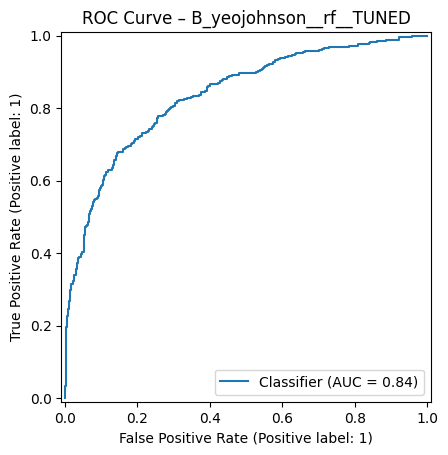

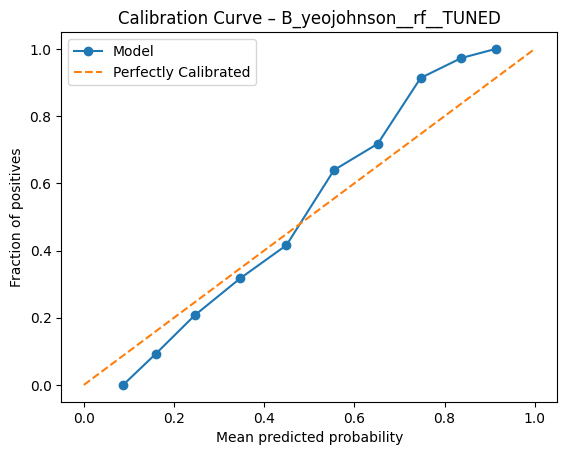


=== Permutation feature importance (AUC decrease) ===
doctor_recc_h1n1               0.110740
opinion_h1n1_risk              0.051752
opinion_h1n1_vacc_effective    0.043465
health_worker                  0.012036
h1n1_knowledge                 0.004571
h1n1_concern                   0.003338
race                           0.003296
age_group                      0.003077
employment_sector              0.002545
marital_status                 0.001844
employment_status              0.001710
opinion_h1n1_sick_from_vacc    0.001644
census_msa                     0.001525
behavioral_avoidance           0.001197
rent_or_own                    0.000952
behavioral_antiviral_meds      0.000556
household_children             0.000388
sex                            0.000204
household_adults              -0.000034
behavioral_large_gatherings   -0.000069
dtype: float64


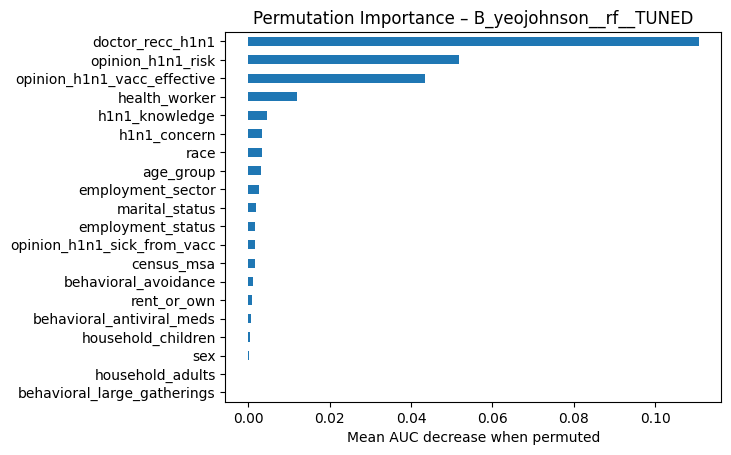


=== SHAP Summary (top 20) ===


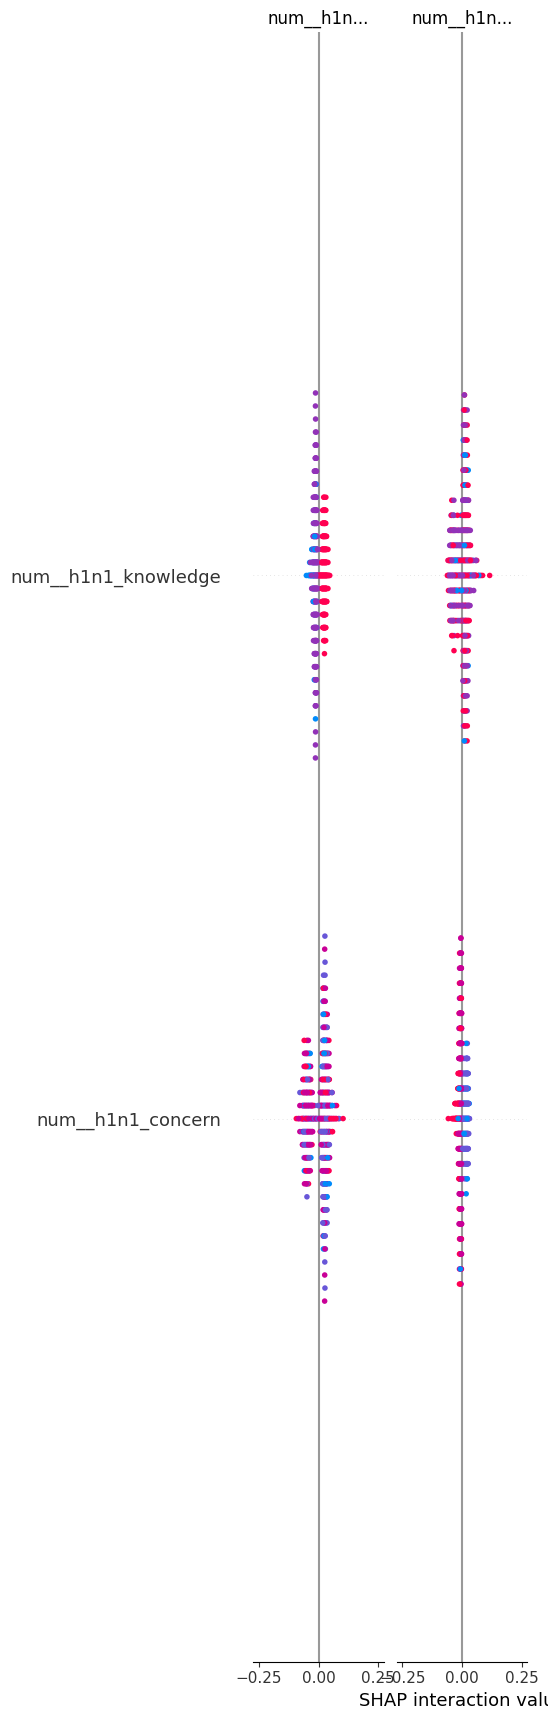

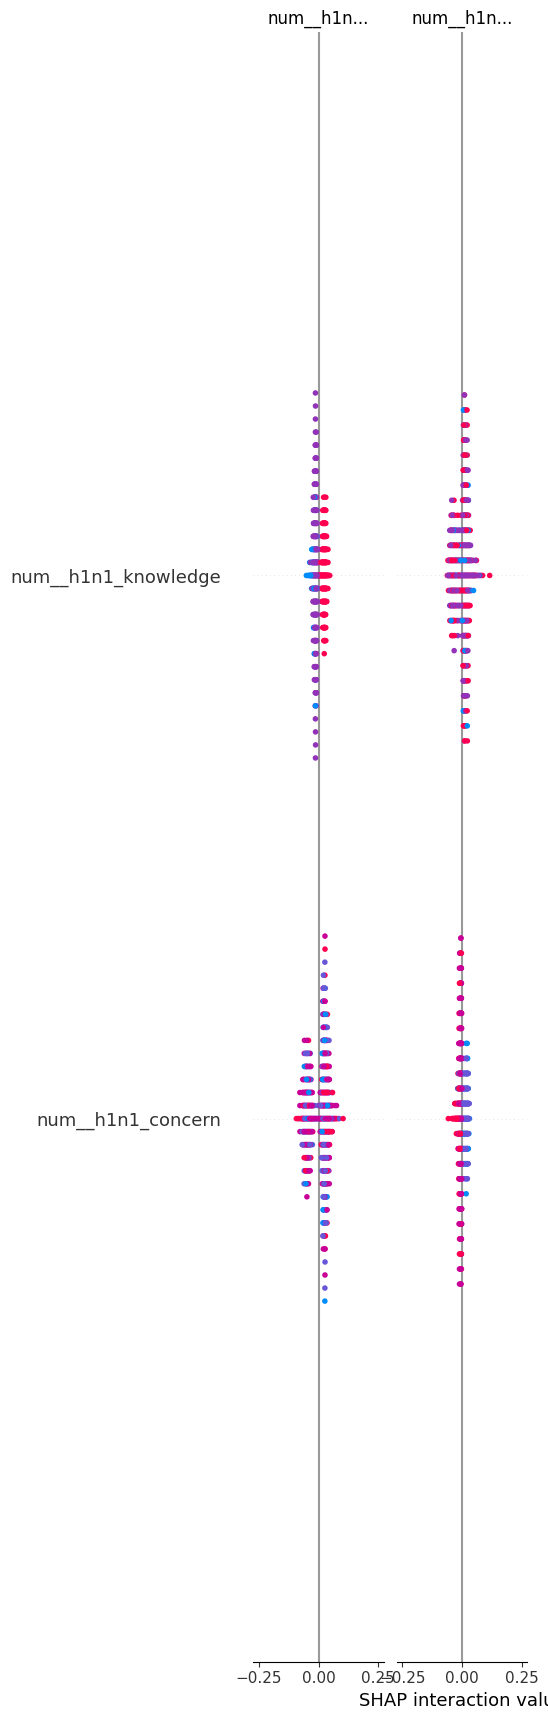

In [65]:
# STEP 9: Diagnostics + SHAP for Best Model
# =====================================================
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)
best_name, best_est = ranked[0]["name"], ranked[0]["estimator"]
best_est.fit(X_tr, y_tr)
va_proba = best_est.predict_proba(X_va)[:, 1]
va_preds = (va_proba >= 0.5).astype(int)
va_auc = roc_auc_score(y_va, va_proba)
va_f1 = f1_score(y_va, va_preds)
print(f"\nBest model hold-out: {best_name} | AUC={va_auc:.4f} | F1={va_f1:.4f}")

RocCurveDisplay.from_predictions(y_va, va_proba)
plt.title(f"ROC Curve – {best_name}")
plt.show()

frac_pos, mean_pred = calibration_curve(y_va, va_proba, n_bins=10, strategy="uniform")
plt.plot(mean_pred, frac_pos, marker="o", label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfectly Calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title(f"Calibration Curve – {best_name}")
plt.legend(); plt.show()

perm = permutation_importance(best_est, X_va, y_va, n_repeats=10,
                               random_state=RANDOM_STATE, n_jobs=N_JOBS, scoring="roc_auc")
imp = pd.Series(perm.importances_mean, index=X_va.columns).sort_values(ascending=False)
print("\n=== Permutation feature importance (AUC decrease) ===")
print(imp.head(20).round(6))
imp.head(20).plot(kind="barh"); plt.gca().invert_yaxis()
plt.title(f"Permutation Importance – {best_name}")
plt.xlabel("Mean AUC decrease when permuted"); plt.show()

# --- SHAP
import shap
rng = np.random.default_rng(7)
sample_idx = rng.choice(len(X_va), size=min(500, len(X_va)), replace=False)
X_shap = X_va.iloc[sample_idx]
pp = best_est.named_steps["pp"]; clf = best_est.named_steps["clf"]
X_proc = pp.transform(X_shap)
try: feat_names = pp.get_feature_names_out()
except: feat_names = [f"f{i}" for i in range(X_proc.shape[1])]

if isinstance(clf, (RandomForestClassifier, DecisionTreeClassifier, XGBClassifier)):
    explainer = shap.TreeExplainer(clf)
elif isinstance(clf, LogisticRegression):
    explainer = shap.LinearExplainer(clf, X_proc)
else:
    explainer = shap.Explainer(clf, X_proc)
shap_values = explainer(X_proc)
print("\n=== SHAP Summary (top 20) ===")
# Beeswarm (feature impact spread)
shap.summary_plot(shap_values, X_proc, feature_names=feat_names, show=True, max_display=20)
# Bar chart of mean absolute SHAP values
shap.summary_plot(shap_values, X_proc, feature_names=feat_names,
                  plot_type="bar", show=True, max_display=20)